In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.functional import accuracy
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as transform
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchmetrics.functional import accuracy
from monai.networks.nets import UNet
from monai.losses import DiceLoss,DiceCELoss ,DiceFocalLoss ,MaskedDiceLoss
from monai.metrics import DiceMetric
import os
import torch.nn.functional as F
from tqdm import tqdm
import tifffile
import random
import cv2
from torchmetrics import Dice

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
device , num_gpus


('cuda', 4)

In [3]:
def binary(org_img):
    #print(np.any(org_img))
    if np.any(org_img):
        normalized_img = (org_img - np.min(org_img)) / (np.max(org_img) - np.min(org_img))
        normalized_img[normalized_img < 0.5] = 0
        normalized_img[normalized_img >= 0.5] = 1
        return normalized_img
    else:
        return org_img
def rgb(org_img):
    normalized_img = (org_img - np.min(org_img)) / (np.max(org_img) - np.min(org_img))
    return normalized_img

In [4]:
class segmentation_dataset(Dataset):
    def __init__(self,image_filenames,mask_filenames,transforms=None):
        self.image_dir = "/scratch/akaniyar/colonoscopy/images/"
        self.mask_dir = "/scratch/akaniyar/colonoscopy/masks/"
        self.transform = transforms
        #self.mask_transform = transforms.Compose([
        self.mask_transform = transform.Compose([ transform.ToPILImage(),
            transform.Resize((128,128), InterpolationMode.BICUBIC),
            transform.Grayscale(num_output_channels = 1),
            transform.ToTensor()])
    
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        
    def __len__(self):
        return len(self.image_filenames)
    
    
    def __getitem__(self, idx):
        img = tifffile.imread(os.path.join(self.image_dir, self.image_filenames[idx]))
        label = tifffile.imread(os.path.join(self.mask_dir, self.mask_filenames[idx]))
        #print(np.unique(img),np.unique(label))
        #label = binary(label.astype(np.float32))
        #img = rgb(img)
        if self.transform is not None:
            img, label = self.transform(img), self.mask_transform(label)
            
        return img, label
        

In [6]:
# Define the file paths
file1_path = '/home/akaniyar/Colonoscopy/data_load_text/np_filenames.txt'
file2_path = '/home/akaniyar/Colonoscopy/data_load_text/np_maskfilenames.txt'
file3_path = '/home/akaniyar/Colonoscopy/data_load_text/wp_filenames.txt'
file4_path = '/home/akaniyar/Colonoscopy/data_load_text/wp_maskfilenames.txt'

# Create empty lists to store image paths
np_filenames = []
np_maskfilenames = []
wp_filenames = []
wp_maskfilenames = []

#Read image paths from file1.txt and append to np_filenames list
with open(file1_path, 'r') as file1:
    for line in file1:
        np_filenames.append(line.strip())

# Read image paths from file2.txt and append to np_maskfilenames list
with open(file2_path, 'r') as file2:
    for line in file2:
        np_maskfilenames.append(line.strip())

# Read image paths from file3.txt and append to wp_filenames list
with open(file3_path, 'r') as file3:
    for line in file3:
        wp_filenames.append(line.strip())

# Read image paths from file4.txt and append to wp_maskfilenames list
with open(file4_path, 'r') as file4:
    for line in file4:
        wp_maskfilenames.append(line.strip())


In [8]:
print(len(np_filenames),len(np_maskfilenames))
print(len(wp_filenames),len(wp_maskfilenames))

15046 15046
3856 3856


In [10]:
image_filenames = wp_filenames[:wp_train_size]+np_filenames[:np_train_size] 
mask_filenames = wp_maskfilenames[:wp_train_size] +  np_maskfilenames[:np_train_size] 
print(len(image_filenames),len(mask_filenames))

18902 18902


In [12]:
# data_transform = transform.Compose([ transform.ToTensor(),transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),transform.Resize((256,256))])

data_transform = transform.Compose([
            transform.ToPILImage(),
            transform.Resize((128,128),InterpolationMode.BICUBIC),
            transform.ToTensor()
        ])

In [14]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
image_filenames_train, image_filenames_test, mask_filenames_train, mask_filenames_test = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42)

# Further splitting the train set into train and validation sets
image_filenames_train, image_filenames_val, mask_filenames_train, mask_filenames_val = train_test_split(
    image_filenames_train, mask_filenames_train, test_size=0.1, random_state=42)

# Creating your segmentation dataset using the split filenames
train_dataset = segmentation_dataset(image_filenames=image_filenames_train,
                                     mask_filenames=mask_filenames_train,
                                     transforms=data_transform)

val_dataset = segmentation_dataset(image_filenames=image_filenames_val,
                                   mask_filenames=mask_filenames_val,
                                   transforms=data_transform)

test_dataset = segmentation_dataset(image_filenames=image_filenames_test,
                                    mask_filenames=mask_filenames_test,
                                    transforms=data_transform)


In [16]:
len(train_dataset),len(val_dataset),len(test_dataset)

(13608, 1513, 3781)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True , num_workers = num_gpus)
val_loader = DataLoader(val_dataset, batch_size=32,shuffle=True,num_workers = num_gpus)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers = num_gpus)

torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.41

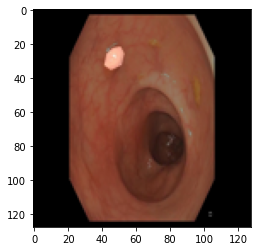

In [20]:
i,l = train_dataset[10000]
print(i.shape ,l.shape)
print(torch.unique(i) , torch.unique(l))
print(i.dtype, l.dtype)
# l = (l == 1.0000 )
# l2 = (l==1)
plt.imshow(i.permute(1,2,0))
plt.imshow(l.permute(1,2,0),alpha = 0.4,cmap = "gray")


In [21]:
from model_org import UNet
# from ynet2d import UNet2D
#from unet import UNet
from torch.nn.parallel import DataParallel

In [22]:
from torchsummary import summary

In [23]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [24]:
model = UNet(n_channels=3,n_classes=1)
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)
#model = NestedUNet()
#model = UNet2D()
#model = UNet()
model = DataParallel(model, device_ids=[0,1,2,3], dim=0)
#model = torch.load("/home/akaniyar/Colonoscopy/all_model/120_CVCscratch.pth")
# saved_model_path = "/home/akaniyar/Colonoscopy/all_model/wp_train_unet30.pth"
# checkpoint = torch.load(saved_model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
summary(model,(3,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
       double_conv-7         [-1, 64, 256, 256]               0
            inconv-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

In [25]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [26]:
#loss_fn = nn.BCELoss(reduction="mean")
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = DiceLoss(sigmoid = True)
#loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
dice = Dice(average='micro').to(device)
loss_fn , optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [27]:
# def dice_coefficient(pred, target):
#     intersection = torch.sum(pred * target)
#     dice = (2. * intersection) / (torch.sum(pred) + torch.sum(target))
#     return dice

In [33]:
def train(epochs,model,dataloader):
    
    train_loss = []
    val_loss = []
    avg_test_loss = []
    avg_iou = []
    avg_iou_val = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for i, (image, label) in enumerate(train_loader):
            #print(image.shape , label.shape)
            image, label = image, label
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            #print(image.shape , label.shape)
            output = model(image)
            # if epoch == 3 and i <=10 :
            #     plt.subplot(1,2,1)
            #     plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())
            #     plt.subplot(1,2,2)
            #     plt.imshow(label[0].permute(1,2,0).cpu().detach().numpy())
            #     plt.show()
            #print(output.shape)
            loss = loss_fn(output, label)
            label = label.to(torch.int64)
            #print(output , label)
            train_iou = dice(output, label)

            
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            avg_iou.append(train_iou.item())
            
            
        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            for i, (image, label) in enumerate(val_loader):
                image, label = image, label
                
                image, label = image.to(device), label.to(device)
                output = model(image)
                # plt.subplot(1,2,1)
                # plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())
                # plt.subplot(1,2,2)
                # plt.imshow(label[0].permute(1,2,0).cpu().detach().numpy())
                # plt.show()
                loss = loss_fn(output, label)
                label = label.to(torch.int64)
                val_iou = dice(output, label)

                val_loss.append(loss.item())
                avg_iou_val.append(val_iou.item())
            
            val_loss_epoch = sum(val_loss) / len(val_loss)
            avg_iou_val_epoch = sum(avg_iou_val) / len(avg_iou_val)
        # print average losses and dice coefficients for the epoch
        train_loss_epoch = sum(train_loss) / len(train_loss)
        
        
        avg_iou_epoch = sum(avg_iou) / len(avg_iou)
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss_epoch:.5f} | Val Loss: {val_loss_epoch:.5f} |Dice Coefficient: {avg_iou_epoch:.5f} | Val Dice Coefficient: {avg_iou_val_epoch:.5f}")
    # torch.save(model.state_dict(),"/home/akaniyar/Colonoscopy/all_model/Wp_training.pth")
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss_fn,
        },
        os.path.join("/home/akaniyar/Colonoscopy/all_model/", f"wp_train_unet80.pth"),
    )
    
if __name__ == '__main__':
    epochs = 10
    train(epochs, model, train_loader)

 10%|█         | 1/10 [09:18<1:23:49, 558.83s/it]

Epoch 1 | Train Loss: 0.00077 | Val Loss: 0.00157 |Dice Coefficient: 0.90127 | Val Dice Coefficient: 0.86571


 20%|██        | 2/10 [16:49<1:05:59, 495.00s/it]

Epoch 2 | Train Loss: 0.00077 | Val Loss: 0.00157 |Dice Coefficient: 0.90232 | Val Dice Coefficient: 0.86437


 30%|███       | 3/10 [24:06<54:42, 468.89s/it]  

Epoch 3 | Train Loss: 0.00076 | Val Loss: 0.00158 |Dice Coefficient: 0.90290 | Val Dice Coefficient: 0.86762


 40%|████      | 4/10 [31:14<45:15, 452.61s/it]

Epoch 4 | Train Loss: 0.00076 | Val Loss: 0.00155 |Dice Coefficient: 0.90344 | Val Dice Coefficient: 0.86835


 50%|█████     | 5/10 [38:13<36:42, 440.48s/it]

Epoch 5 | Train Loss: 0.00076 | Val Loss: 0.00154 |Dice Coefficient: 0.90319 | Val Dice Coefficient: 0.86487


 60%|██████    | 6/10 [45:30<29:17, 439.27s/it]

Epoch 6 | Train Loss: 0.00076 | Val Loss: 0.00164 |Dice Coefficient: 0.90291 | Val Dice Coefficient: 0.85596


 70%|███████   | 7/10 [53:21<22:28, 449.55s/it]

Epoch 7 | Train Loss: 0.00079 | Val Loss: 0.00161 |Dice Coefficient: 0.90055 | Val Dice Coefficient: 0.85697


 80%|████████  | 8/10 [1:01:21<15:18, 459.46s/it]

Epoch 8 | Train Loss: 0.00079 | Val Loss: 0.00160 |Dice Coefficient: 0.90064 | Val Dice Coefficient: 0.85845


 90%|█████████ | 9/10 [1:09:10<07:42, 462.17s/it]

Epoch 9 | Train Loss: 0.00078 | Val Loss: 0.00160 |Dice Coefficient: 0.90108 | Val Dice Coefficient: 0.85864


100%|██████████| 10/10 [1:16:56<00:00, 461.64s/it]

Epoch 10 | Train Loss: 0.00077 | Val Loss: 0.00160 |Dice Coefficient: 0.90147 | Val Dice Coefficient: 0.85766


In [34]:
def test():
    test_loss = 0
    test_dice_coefficient = []
    test_dice_loss = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            image, label = data
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            # calculate dice coefficient and dice loss
            #pred = (output > 0.5).float()
            label = label.to(torch.int64)
            testdice = dice(output, label)
            dice_loss = 1 - testdice

            test_loss += loss.item()
            test_dice_coefficient.append(testdice.item())
            test_dice_loss += dice_loss.item()

        # calculate average test loss, dice coefficient, and dice loss
        #print(len(test_dice_coefficient))
    test_loss /= len(test_loader)
    avg_test_dice_coefficient = sum(test_dice_coefficient)/len(test_dice_coefficient)
    test_dice_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.5f} | Dice Loss: {test_dice_loss:.5f} | Dice Coefficient: {avg_test_dice_coefficient:.5f}")


    
    
test()

Test Loss: 0.00151 | Dice Loss: 0.12981 | Dice Coefficient: 0.87019


0
1
2
3
4


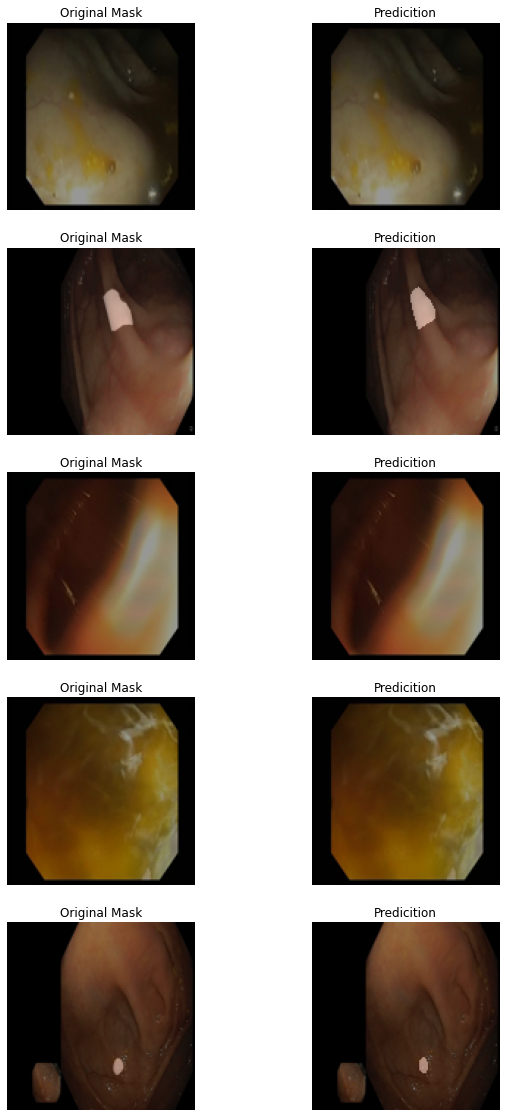

In [39]:
n_max_imgs = 5

plt.figure(figsize=(10, 20))
for n in range(n_max_imgs):
    model.eval()
    print(n)
    #print(len(test_dataset))
    x, t = val_dataset[n+100]
    x,t = x.to(device) , t.to(device)
    y = model(x.unsqueeze(0)) 
    y_label = (y>0).int().squeeze()
    
    #t = np.squeeze(t) 
    #print(torch.unique(y_label))
    t = t.cpu()
    
    z = y_label.cpu()
    
    plt.subplot(n_max_imgs, 2, 2*n+1)
    plt.imshow(x.cpu().permute(1,2,0),cmap = "gray")
    plt.imshow(t.permute(1,2,0),cmap = "gray",alpha = 0.4)
    plt.title("Original Mask")
    plt.axis(False);
    plt.subplot(n_max_imgs, 2, 2*n+2)
    plt.imshow(x.cpu().permute(1,2,0))
    plt.imshow(z,alpha = 0.4,cmap = "gray")
    plt.title("Predicition")
    plt.axis(False);
    plt.savefig("overleafasu_mayo_results.png",dpi=300)
plt.show()